In [1]:
#Upload VLE dataset
import pandas as pd

# Replace 'your_file.csv' with the path to your CSV file
file_path = 'OUData/studentVle.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print(df.head())

  code_module code_presentation  id_student  id_site  date  sum_click
0         AAA             2013J       28400   546652   -10          4
1         AAA             2013J       28400   546652   -10          1
2         AAA             2013J       28400   546652   -10          1
3         AAA             2013J       28400   546614   -10         11
4         AAA             2013J       28400   546714   -10          1


In [2]:
#Let's aggregate the sum_click to get total daily clicks and also ignore different types of sites
# List of columns to group by. This should include all columns except 'sum_click' and 'id_site'
columns_to_group_by = ['code_module', 'code_presentation', 'id_student','date'] 

# Group by the specified columns and sum the 'sum_click' for each group
df_grouped = df.groupby(columns_to_group_by).agg(total_daily_clicks=('sum_click', 'sum')).reset_index()
df_grouped.head(100)

,code_module,code_presentation,id_student,date,total_daily_clicks
0,AAA,2013J,11391,-5,98
1,AAA,2013J,11391,0,49
2,AAA,2013J,11391,1,127
3,AAA,2013J,11391,2,4
4,AAA,2013J,11391,6,3
...,...,...,...,...,...
95,AAA,2013J,28400,150,3
96,AAA,2013J,28400,154,27
97,AAA,2013J,28400,155,1
98,AAA,2013J,28400,156,25


In [3]:
import numpy as np
#create function that returns df with all dates included and 0 for total_daily_clicks for missing dates
def complete_df(code_module,code_presentation,id_student):
    #filter by course, presentation, and student
    filtered_df = df_grouped[(df_grouped['code_module']==code_module) & (df_grouped['code_presentation']==code_presentation) & (df_grouped['id_student']==id_student)]

    #For missing dates, we will make total_daily_clicks to be 0
  
    # Step 1: Find min and max date values
    min_day = filtered_df['date'].min()
    max_day = filtered_df['date'].max()

    # Step 2: Generate complete range of days
    all_days = np.arange(min_day, max_day + 1)  # +1 to include the last day

    # Step 3: Create a DataFrame with all days
    df_all_days = pd.DataFrame({'date': all_days, 'code_module': code_module, 'code_presentation': code_presentation, 'id_student': id_student})
    df_all_days = df_all_days.assign(total_daily_clicks=0)

    # Merge to update total_daily_clicks where data exists
    df_complete = pd.merge(df_all_days, filtered_df[['date', 'total_daily_clicks']], on='date', how='left', suffixes=('', '_update'))
    df_complete['total_daily_clicks'] = df_complete['total_daily_clicks_update'].fillna(df_complete['total_daily_clicks'])
    df_complete.drop(columns='total_daily_clicks_update', inplace=True)

    return df_complete

In [4]:
# The different modules are ['AAA', 'BBB', 'CCC', 'DDD', 'EEE', 'FFF', 'GGG']
#For AAA, the presentations are 2013J and 2014J.
#For BBB, the presentations are 2013B, 2013J, 2014B, 2014J
#For CCC, the presentations are 2014B, 2014J
#For DDD, the presentations are 2013B, 2013J, 2014B, 2014J
#For EEE, the presentations are 2013J, 2014B, 2014J
#For FFF, the presentations are 2013B, 2013J, 2014B, 2014J
#For GGG, the presentations are 2013J, 2014B, 2014J

In [5]:
#Create a new dataframe that has student id, mean of total daily clicks, ratio of zero-click days, and standard deviation of total daily clicks
def df_interaction(code_module,code_presentation):

    list_student_ids = df_grouped[(df_grouped['code_module']==code_module) & (df_grouped['code_presentation']==code_presentation)]['id_student'].unique()
    # Initialize an empty list to store the data
    data = []

    # Loop through each student ID
    for student_id in list_student_ids:
        # Filter the DataFrame for the current student ID
        filtered_df = complete_df(code_module,code_presentation,student_id)

        # Calculate the mean of the 'total_clicks' column for this student
        mean_clicks = filtered_df['total_daily_clicks'].mean()

        # Count the number of zero-click days
        zero_click_days = (filtered_df['total_daily_clicks'] == 0).sum()

        # Calculate the total number of days recorded for the student
        total_days = filtered_df.shape[0]

        # Compute the ratio of zero-click days
        zero_day_ratio = zero_click_days / total_days

        # Calculate the standard deviation of 'total_daily_clicks'
        stdv = filtered_df['total_daily_clicks'].std()
        
        # Sum of 'total_daily_clicks' for this student
        total_clicks = filtered_df['total_daily_clicks'].sum()

        # Append the student ID, mean clicks, zero_day_ratio, and standard deviation to the list
        data.append([student_id, mean_clicks, zero_day_ratio, stdv, total_clicks])

    # Create a new DataFrame from the list
    df_summary = pd.DataFrame(data, columns=['id_student', 'mean_clicks', 'zero_day_ratio', 'stdv', 'total_clicks'])
    return df_summary


In [6]:
df_AAA_2013J = df_interaction('AAA','2013J')
df_AAA_2013J

,id_student,mean_clicks,zero_day_ratio,stdv,total_clicks
0,11391,3.606178,0.845560,13.728518,934.0
1,28400,5.740000,0.680000,14.336476,1435.0
2,30268,12.217391,0.478261,17.079910,281.0
3,31604,7.847273,0.552727,13.391301,2158.0
4,32885,4.007752,0.728682,10.833725,1034.0
...,...,...,...,...,...
373,2689958,14.082437,0.078853,13.028069,3929.0
374,2691206,9.043307,0.240157,11.537278,2297.0
375,2691244,1.728938,0.721612,4.201690,472.0
376,2694424,15.282609,0.253623,17.704848,4218.0


In [7]:
#Load StudentInfo dataset that has the outcomes of each student for a given module and presentation
file_path = 'OUData/studentInfo.csv'
df_student_info = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print(df_student_info.head())

  code_module code_presentation  id_student gender                region  \
0         AAA             2013J       11391      M   East Anglian Region   
1         AAA             2013J       28400      F              Scotland   
2         AAA             2013J       30268      F  North Western Region   
3         AAA             2013J       31604      F     South East Region   
4         AAA             2013J       32885      F  West Midlands Region   

       highest_education imd_band age_band  num_of_prev_attempts  \
0       HE Qualification  90-100%     55<=                     0   
1       HE Qualification   20-30%    35-55                     0   
2  A Level or Equivalent   30-40%    35-55                     0   
3  A Level or Equivalent   50-60%    35-55                     0   
4     Lower Than A Level   50-60%     0-35                     0   

   studied_credits disability final_result  
0              240          N         Pass  
1               60          N         Pass  

In [8]:
#convert final_result column to 0's and 1's
df_student_info['outcome'] = np.where(df_student_info['final_result'].isin(['Pass', 'Distinction']), 1, 0)
df_student_info

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,outcome
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,1
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,1
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,1
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail,0
32589,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction,1
32590,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass,1
32591,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn,0


In [9]:
# List of columns you want to keep
columns_to_keep = ['code_module', 'code_presentation', 'id_student', 'outcome']

# Filter the DataFrame to keep only the specified columns
df_student_info = df_student_info[columns_to_keep]


In [10]:
#filter for specific module and presentation
code_module = 'AAA'
code_presentation = '2013J'
df_student_info_AAA_2013J = df_student_info[(df_student_info['code_module']==code_module )& (df_student_info['code_presentation']==code_presentation)]

In [11]:
#join student info dataset with interaction dataset
merged_df_AAA_2013J = pd.merge(df_AAA_2013J, df_student_info_AAA_2013J, on='id_student', how='inner')
merged_df_AAA_2013J

,id_student,mean_clicks,zero_day_ratio,stdv,total_clicks,code_module,code_presentation,outcome
0,11391,3.606178,0.845560,13.728518,934.0,AAA,2013J,1
1,28400,5.740000,0.680000,14.336476,1435.0,AAA,2013J,1
2,30268,12.217391,0.478261,17.079910,281.0,AAA,2013J,0
3,31604,7.847273,0.552727,13.391301,2158.0,AAA,2013J,1
4,32885,4.007752,0.728682,10.833725,1034.0,AAA,2013J,1
...,...,...,...,...,...,...,...,...
373,2689958,14.082437,0.078853,13.028069,3929.0,AAA,2013J,1
374,2691206,9.043307,0.240157,11.537278,2297.0,AAA,2013J,1
375,2691244,1.728938,0.721612,4.201690,472.0,AAA,2013J,1
376,2694424,15.282609,0.253623,17.704848,4218.0,AAA,2013J,1


In [12]:
#count how many 0's and 1's occur in outcome column
value_counts = merged_df_AAA_2013J['outcome'].value_counts()

# Retrieving the counts for 0 and 1
count_0 = value_counts.get(0, 0)
count_1 = value_counts.get(1, 0)

print(f"Count of 0s: {count_0}")
print(f"Count of 1s: {count_1}")

Count of 0s: 100
Count of 1s: 278


In [13]:
# We have an imbalanced dataset

In [14]:
#Perform logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from collections import Counter

#Define X and Y using dataset
X = merged_df_AAA_2013J.iloc[:,1:5].values
Y = merged_df_AAA_2013J.iloc[:,7].values

#Splitting the dataset into the Training set and Test set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = 2)

#Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)

#Fitting Logistic Regression to the Training set
classifier = LogisticRegression()
classifier.fit(X_train,Y_train)

#Predicting the Test set results
Y_pred = classifier.predict(X_test)

#Making the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred)
print(f'accuracy:{cm.trace()/len(Y_test)}')
print(f'confusion matrix:\n{cm}')

#check the precision, recall, and f1-score
from sklearn.metrics import classification_report
print(f'classification report:\n{classification_report(Y_test,Y_pred)}')

accuracy:0.7763157894736842
confusion matrix:
[[ 6 17]
 [ 0 53]]
classification report:
              precision    recall  f1-score   support

           0       1.00      0.26      0.41        23
           1       0.76      1.00      0.86        53

    accuracy                           0.78        76
   macro avg       0.88      0.63      0.64        76
weighted avg       0.83      0.78      0.73        76



In [15]:
#Note that recall for the negative outcome is very low at .26; we want to improve recall for the negative outcome.
#That is, we want to catch as many of the students in danger of failing or withdrawing.

In [16]:
pip install -U imbalanced-learn

  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/6e/1b/66764ecf370e797759be06fb38c11640ea1f9456ae10f8640a33cfa726ea/imbalanced_learn-0.12.2-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/258.0 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/258.0 kB 660.6 kB/s eta 0:00:01
   -------------- ------------------------- 92.2/258.0 kB 1.1 MB/s eta 0:00:01
   -------------------------- ------------- 174.1/258.0 kB 1.5 MB/s eta 0:00:01
   ---------------------------------------  256.0/258.0 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 258.0/258.0 kB 1.4 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.12.0
    Uninstalling imbalanced-learn-0.12.0:
      Successfully uninstalled imbalanced-learn-0.12.0
Note: you may need to restart the kernel to use updated packages.


In [17]:

#try oversampling and undersampling to get around the imbalanced data problem
import imblearn
# Oversampling and under sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from collections import Counter

#Oversampling approach
# Randomly over-sample the minority class
ros = RandomOverSampler(random_state=42, sampling_strategy='minority')
X_train_ros, Y_train_ros= ros.fit_resample(X_train, Y_train)
# Check the number of records after over sampling
print(sorted(Counter(Y_train_ros).items()))

#Fitting Logistic Regression to the randomly over-sampled Training set
classifier_ros = LogisticRegression()
classifier_ros.fit(X_train_ros,Y_train_ros)

#Predicting the Test set results
Y_pred_ros = classifier_ros.predict(X_test)

#Making the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred_ros)
print(f'accuracy:{cm.trace()/len(Y_test)}')
print(f'confusion matrix:\n{cm}')

#check the precision, recall, and f1-score
from sklearn.metrics import classification_report
print(f'classification report:\n{classification_report(Y_test,Y_pred_ros)}')

[(0, 225), (1, 225)]
accuracy:0.8552631578947368
confusion matrix:
[[13 10]
 [ 1 52]]
classification report:
              precision    recall  f1-score   support

           0       0.93      0.57      0.70        23
           1       0.84      0.98      0.90        53

    accuracy                           0.86        76
   macro avg       0.88      0.77      0.80        76
weighted avg       0.87      0.86      0.84        76



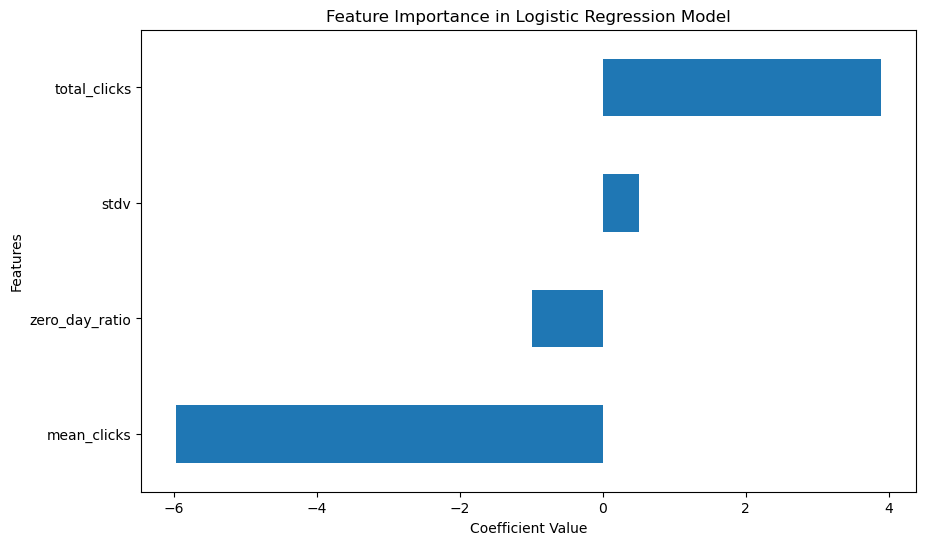

In [18]:
# Extract the coefficients
coefficients = classifier_ros.coef_[0]  # Get the coefficients for the features

# If you have feature names available (e.g., from a DataFrame)
feature_names = merged_df_AAA_2013J.iloc[:,1:5].columns

# Create a Series for easier visualization (if using pandas)
import pandas as pd
feature_importance = pd.Series(coefficients, index=feature_names)

# Visualizing Feature Importance
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 6))
feature_importance.sort_values().plot(kind='barh')
plt.title('Feature Importance in Logistic Regression Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()

In [19]:
#KNN with oversampling

#Perform cross validation to find the optimal number of neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)
  
# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(X_train_ros, Y_train_ros)
# print optimal number of neighbors
print(grid_search.best_params_)
# print corresponding training accuracy
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

#Perform KNN using k=1 neighbors
from sklearn.neighbors import KNeighborsClassifier
classifierKNN = KNeighborsClassifier(n_neighbors = 1, metric = 'minkowski', p =2) #euclidean metric
classifierKNN.fit(X_train_ros,Y_train_ros)

#Predicting the Test set results
Y_pred = classifierKNN.predict(X_test)

#Making the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred)
print(f'accuracy:{cm.trace()/len(Y_test)}')
print(f'confusion matrix:\n{cm}')

#check the precision, recall, and f1-score
from sklearn.metrics import classification_report
print(f'classification report:\n{classification_report(Y_test,Y_pred)}')

Fitting 10 folds for each of 30 candidates, totalling 300 fits
{'n_neighbors': 1}
Accuracy for our training dataset with tuning is : 92.89%
accuracy:0.8026315789473685
confusion matrix:
[[14  9]
 [ 6 47]]
classification report:
              precision    recall  f1-score   support

           0       0.70      0.61      0.65        23
           1       0.84      0.89      0.86        53

    accuracy                           0.80        76
   macro avg       0.77      0.75      0.76        76
weighted avg       0.80      0.80      0.80        76



In [20]:
#Linear SVM

#Perform cross validation to find the optimal C value for SVM
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
svc = SVC()
C_range = list(np.arange(0.05,1,.05))
parameters = {'kernel':['linear'], 'C':C_range}
  
grid = GridSearchCV(svc, parameters, cv=10, scoring='accuracy', verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(X_train_ros, Y_train_ros) 
# print optimal C value
print(grid_search.best_params_)
# print corresponding training accuracy
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )
# print best estimator
print(grid.best_estimator_)

#SVM using optimal C
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', C=.95, decision_function_shape='ovr')
svclassifier.fit(X_train_ros, Y_train_ros)  

#Predicting the Test set results
Y_pred = svclassifier.predict(X_test)

#Making the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred)
print(f'accuracy:{cm.trace()/len(Y_test)}')
print(f'confusion matrix:\n{cm}')

#check the precision, recall, and f1-score
from sklearn.metrics import classification_report
print(f'classification report:\n{classification_report(Y_test,Y_pred)}')

Fitting 10 folds for each of 19 candidates, totalling 190 fits
{'C': 0.9500000000000001, 'kernel': 'linear'}
Accuracy for our training dataset with tuning is : 84.22%
SVC(C=0.9500000000000001, kernel='linear')
accuracy:0.8552631578947368
confusion matrix:
[[14  9]
 [ 2 51]]
classification report:
              precision    recall  f1-score   support

           0       0.88      0.61      0.72        23
           1       0.85      0.96      0.90        53

    accuracy                           0.86        76
   macro avg       0.86      0.79      0.81        76
weighted avg       0.86      0.86      0.85        76



In [21]:
#Kernal SVM

#Perform cross validation to find the optimal C value for kernel SVM
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
svc = SVC()
C_range = list(np.arange(1,20,.5))
parameters = {'kernel':['rbf'], 'C':C_range}
  
grid = GridSearchCV(svc, parameters, cv=10, scoring='accuracy', verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(X_train_ros, Y_train_ros) 
# print optimal C value
print(grid_search.best_params_)
# print corresponding training accuracy
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )
# print best estimator
print(grid.best_estimator_)

#Kernel SVM; use gaussian rbf kernel and optimal C value

svclassifier = SVC(kernel='rbf', C=15)
svclassifier.fit(X_train_ros, Y_train_ros)  

#Predicting the Test set results
Y_pred = svclassifier.predict(X_test)

#Making the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred)
print(f'accuracy:{cm.trace()/len(Y_test)}')
print(f'confusion matrix:\n{cm}')

#check the precision, recall, and f1-score
from sklearn.metrics import classification_report
print(f'classification report:\n{classification_report(Y_test,Y_pred)}')

Fitting 10 folds for each of 38 candidates, totalling 380 fits
{'C': 15.0, 'kernel': 'rbf'}
Accuracy for our training dataset with tuning is : 89.33%
SVC(C=15.0)
accuracy:0.8552631578947368
confusion matrix:
[[14  9]
 [ 2 51]]
classification report:
              precision    recall  f1-score   support

           0       0.88      0.61      0.72        23
           1       0.85      0.96      0.90        53

    accuracy                           0.86        76
   macro avg       0.86      0.79      0.81        76
weighted avg       0.86      0.86      0.85        76



In [22]:
#Adaboost with oversampling
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=500, random_state=0)
clf.fit(X_train_ros, Y_train_ros)
#Predicting the Test set results
Y_pred = clf.predict(X_test)

#Making the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred)
print(f'accuracy:{cm.trace()/len(Y_test)}')
print(f'confusion matrix:\n{cm}')

#check the precision, recall, and f1-score
from sklearn.metrics import classification_report
print(f'classification report:\n{classification_report(Y_test,Y_pred)}')

accuracy:0.8421052631578947
confusion matrix:
[[13 10]
 [ 2 51]]
classification report:
              precision    recall  f1-score   support

           0       0.87      0.57      0.68        23
           1       0.84      0.96      0.89        53

    accuracy                           0.84        76
   macro avg       0.85      0.76      0.79        76
weighted avg       0.85      0.84      0.83        76



In [23]:
#GradientBoosting with oversampling
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=2, random_state=0).fit(X_train_ros, Y_train_ros)

#Predicting the Test set results
Y_pred = clf.predict(X_test)

#Making the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred)
print(f'accuracy:{cm.trace()/len(Y_test)}')
print(f'confusion matrix:\n{cm}')

#check the precision, recall, and f1-score
from sklearn.metrics import classification_report
print(f'classification report:\n{classification_report(Y_test,Y_pred)}')

accuracy:0.8947368421052632
confusion matrix:
[[17  6]
 [ 2 51]]
classification report:
              precision    recall  f1-score   support

           0       0.89      0.74      0.81        23
           1       0.89      0.96      0.93        53

    accuracy                           0.89        76
   macro avg       0.89      0.85      0.87        76
weighted avg       0.89      0.89      0.89        76



In [24]:
#Perform Random Forest with oversampling

#Fitting random forest classifier to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(criterion='entropy', n_estimators=100, random_state=0)
classifier.fit(X_train_ros,Y_train_ros)

#Predicting the Test set results
Y_pred_rf = classifier.predict(X_test)

#Making the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred_rf)
print(f'accuracy:{cm.trace()/len(Y_test)}')
print(f'confusion matrix:\n{cm}')

#check the precision, recall, and f1-score
from sklearn.metrics import classification_report
print(f'classification report:\n{classification_report(Y_test,Y_pred_rf)}')

accuracy:0.8552631578947368
confusion matrix:
[[15  8]
 [ 3 50]]
classification report:
              precision    recall  f1-score   support

           0       0.83      0.65      0.73        23
           1       0.86      0.94      0.90        53

    accuracy                           0.86        76
   macro avg       0.85      0.80      0.82        76
weighted avg       0.85      0.86      0.85        76



In [25]:
#Fitting decision tree classifier to the Training set with oversampling
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion='entropy', random_state=0)
classifier.fit(X_train_ros,Y_train_ros)

#Predicting the Test set results
Y_pred = classifier.predict(X_test)

#Making the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred)
print(f'accuracy:{cm.trace()/len(Y_test)}')
print(f'confusion matrix:\n{cm}')

#check the precision, recall, and f1-score
from sklearn.metrics import classification_report
print(f'classification report:\n{classification_report(Y_test,Y_pred)}')

accuracy:0.8026315789473685
confusion matrix:
[[13 10]
 [ 5 48]]
classification report:
              precision    recall  f1-score   support

           0       0.72      0.57      0.63        23
           1       0.83      0.91      0.86        53

    accuracy                           0.80        76
   macro avg       0.77      0.74      0.75        76
weighted avg       0.80      0.80      0.80        76



In [26]:
#Undersampling approach

# Randomly under sample the majority class
rus = RandomUnderSampler(random_state=42)
X_train_rus, Y_train_rus= rus.fit_resample(X_train, Y_train)
# Check the number of records after under sampling
print(sorted(Counter(Y_train_rus).items()))

#Fitting Logistic Regression to the randomly under-sampled Training set
classifier_rus = LogisticRegression()
classifier_rus.fit(X_train_rus,Y_train_rus)

#Predicting the Test set results
Y_pred_rus = classifier_rus.predict(X_test)

#Making the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred_rus)
print(f'accuracy:{cm.trace()/len(Y_test)}')
print(f'confusion matrix:\n{cm}')

#check the precision, recall, and f1-score
from sklearn.metrics import classification_report
print(f'classification report:\n{classification_report(Y_test,Y_pred_rus)}')

[(0, 77), (1, 77)]
accuracy:0.8157894736842105
confusion matrix:
[[19  4]
 [10 43]]
classification report:
              precision    recall  f1-score   support

           0       0.66      0.83      0.73        23
           1       0.91      0.81      0.86        53

    accuracy                           0.82        76
   macro avg       0.79      0.82      0.80        76
weighted avg       0.84      0.82      0.82        76



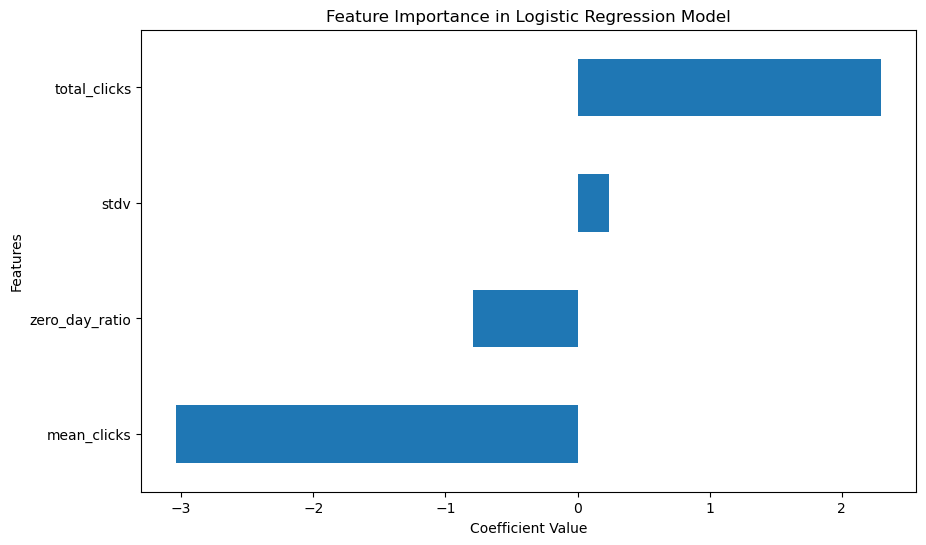

In [27]:
# Extract the coefficients
coefficients = classifier_rus.coef_[0]  # Get the coefficients for the features

# If you have feature names available (e.g., from a DataFrame)
feature_names = merged_df_AAA_2013J.iloc[:,1:5].columns

# Create a Series for easier visualization (if using pandas)
import pandas as pd
feature_importance = pd.Series(coefficients, index=feature_names)

# Visualizing Feature Importance
plt.figure(figsize=(10, 6))
feature_importance.sort_values().plot(kind='barh')
plt.title('Feature Importance in Logistic Regression Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()

In [28]:
#KNN with undersampling

#Perform cross validation to find the optimal number of neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)
  
# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(X_train_rus, Y_train_rus)
# print optimal number of neighbors
print(grid_search.best_params_)
# print corresponding training accuracy
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

#Perform KNN using k=4 neighbors
from sklearn.neighbors import KNeighborsClassifier
classifierKNN = KNeighborsClassifier(n_neighbors = 4, metric = 'minkowski', p =2) #euclidean metric
classifierKNN.fit(X_train_rus,Y_train_rus)

#Predicting the Test set results
Y_pred = classifierKNN.predict(X_test)

#Making the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred)
print(f'accuracy:{cm.trace()/len(Y_test)}')
print(f'confusion matrix:\n{cm}')

#check the precision, recall, and f1-score
from sklearn.metrics import classification_report
print(f'classification report:\n{classification_report(Y_test,Y_pred)}')

Fitting 10 folds for each of 30 candidates, totalling 300 fits
{'n_neighbors': 4}
Accuracy for our training dataset with tuning is : 80.00%
accuracy:0.7368421052631579
confusion matrix:
[[19  4]
 [16 37]]
classification report:
              precision    recall  f1-score   support

           0       0.54      0.83      0.66        23
           1       0.90      0.70      0.79        53

    accuracy                           0.74        76
   macro avg       0.72      0.76      0.72        76
weighted avg       0.79      0.74      0.75        76



In [29]:
#Linear SVM

#Perform cross validation to find the optimal C value for SVM
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
svc = SVC()
C_range = list(np.arange(0.05,1,.05))
parameters = {'kernel':['linear'], 'C':C_range}
  
grid = GridSearchCV(svc, parameters, cv=10, scoring='accuracy', verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(X_train_rus, Y_train_rus) 
# print optimal C value
print(grid_search.best_params_)
# print corresponding training accuracy
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )
# print best estimator
print(grid.best_estimator_)

#SVM using optimal C
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', C=.95, decision_function_shape='ovr')
svclassifier.fit(X_train_rus, Y_train_rus)  

#Predicting the Test set results
Y_pred = svclassifier.predict(X_test)

#Making the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred)
print(f'accuracy:{cm.trace()/len(Y_test)}')
print(f'confusion matrix:\n{cm}')

#check the precision, recall, and f1-score
from sklearn.metrics import classification_report
print(f'classification report:\n{classification_report(Y_test,Y_pred)}')

Fitting 10 folds for each of 19 candidates, totalling 190 fits
{'C': 0.9500000000000001, 'kernel': 'linear'}
Accuracy for our training dataset with tuning is : 82.04%
SVC(C=0.9500000000000001, kernel='linear')
accuracy:0.8026315789473685
confusion matrix:
[[19  4]
 [11 42]]
classification report:
              precision    recall  f1-score   support

           0       0.63      0.83      0.72        23
           1       0.91      0.79      0.85        53

    accuracy                           0.80        76
   macro avg       0.77      0.81      0.78        76
weighted avg       0.83      0.80      0.81        76



In [30]:
#Kernal SVM

#Perform cross validation to find the optimal C value for kernel SVM
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
svc = SVC()
C_range = list(np.arange(1,20,.5))
parameters = {'kernel':['rbf'], 'C':C_range}
  
grid = GridSearchCV(svc, parameters, cv=10, scoring='accuracy', verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(X_train_rus, Y_train_rus) 
# print optimal C value
print(grid_search.best_params_)
# print corresponding training accuracy
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )
# print best estimator
print(grid.best_estimator_)

#Kernel SVM; use gaussian rbf kernel and optimal C value

svclassifier = SVC(kernel='rbf', C=11.5)
svclassifier.fit(X_train_rus, Y_train_rus)  

#Predicting the Test set results
Y_pred = svclassifier.predict(X_test)

#Making the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred)
print(f'accuracy:{cm.trace()/len(Y_test)}')
print(f'confusion matrix:\n{cm}')

#check the precision, recall, and f1-score
from sklearn.metrics import classification_report
print(f'classification report:\n{classification_report(Y_test,Y_pred)}')

Fitting 10 folds for each of 38 candidates, totalling 380 fits
{'C': 11.5, 'kernel': 'rbf'}
Accuracy for our training dataset with tuning is : 82.54%
SVC(C=11.5)
accuracy:0.8157894736842105
confusion matrix:
[[16  7]
 [ 7 46]]
classification report:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        23
           1       0.87      0.87      0.87        53

    accuracy                           0.82        76
   macro avg       0.78      0.78      0.78        76
weighted avg       0.82      0.82      0.82        76



In [31]:
#Adaboost with undersampling
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=500, random_state=0)
clf.fit(X_train_rus, Y_train_rus)
#Predicting the Test set results
Y_pred = clf.predict(X_test)

#Making the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred)
print(f'accuracy:{cm.trace()/len(Y_test)}')
print(f'confusion matrix:\n{cm}')

#check the precision, recall, and f1-score
from sklearn.metrics import classification_report
print(f'classification report:\n{classification_report(Y_test,Y_pred)}')

accuracy:0.7236842105263158
confusion matrix:
[[18  5]
 [16 37]]
classification report:
              precision    recall  f1-score   support

           0       0.53      0.78      0.63        23
           1       0.88      0.70      0.78        53

    accuracy                           0.72        76
   macro avg       0.71      0.74      0.71        76
weighted avg       0.77      0.72      0.73        76



In [32]:
#GradientBoosting with undersampling
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=2, random_state=0).fit(X_train_rus, Y_train_rus)

#Predicting the Test set results
Y_pred = clf.predict(X_test)

#Making the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred)
print(f'accuracy:{cm.trace()/len(Y_test)}')
print(f'confusion matrix:\n{cm}')

#check the precision, recall, and f1-score
from sklearn.metrics import classification_report
print(f'classification report:\n{classification_report(Y_test,Y_pred)}')

accuracy:0.7631578947368421
confusion matrix:
[[19  4]
 [14 39]]
classification report:
              precision    recall  f1-score   support

           0       0.58      0.83      0.68        23
           1       0.91      0.74      0.81        53

    accuracy                           0.76        76
   macro avg       0.74      0.78      0.75        76
weighted avg       0.81      0.76      0.77        76



In [33]:
#Perform Random Forest with undersampling

#Fitting random forest classifier to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(criterion='entropy', n_estimators=100, random_state=0)
classifier.fit(X_train_rus,Y_train_rus)

#Predicting the Test set results
Y_pred_rf = classifier.predict(X_test)

#Making the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred_rf)
print(f'accuracy:{cm.trace()/len(Y_test)}')
print(f'confusion matrix:\n{cm}')

#check the precision, recall, and f1-score
from sklearn.metrics import classification_report
print(f'classification report:\n{classification_report(Y_test,Y_pred_rf)}')

accuracy:0.7763157894736842
confusion matrix:
[[18  5]
 [12 41]]
classification report:
              precision    recall  f1-score   support

           0       0.60      0.78      0.68        23
           1       0.89      0.77      0.83        53

    accuracy                           0.78        76
   macro avg       0.75      0.78      0.75        76
weighted avg       0.80      0.78      0.78        76



<Axes: title={'center': 'Feature Importances'}>

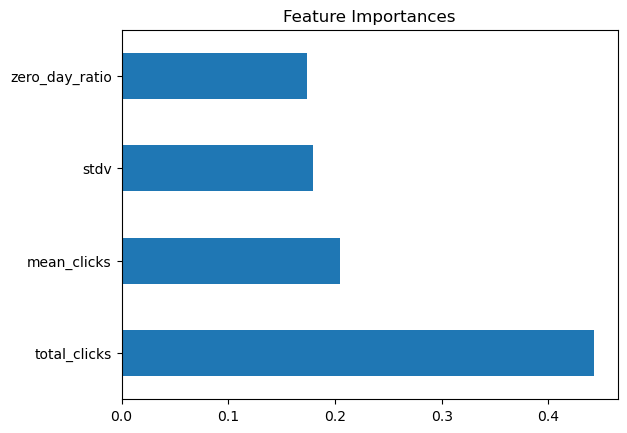

In [34]:
# get importance
importances = classifier.feature_importances_
from matplotlib import pyplot as plt
plt.title('Feature Importances')
plt.xlabel('Relative Importance')

feat_importances = pd.Series(classifier.feature_importances_, index=merged_df_AAA_2013J.iloc[:,1:5].columns)
feat_importances.nlargest(4).plot(kind='barh')

In [35]:
#Fitting decision tree classifier to the Training set with undersampling
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion='entropy', random_state=0)
classifier.fit(X_train_rus,Y_train_rus)

#Predicting the Test set results
Y_pred = classifier.predict(X_test)

#Making the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred)
print(f'accuracy:{cm.trace()/len(Y_test)}')
print(f'confusion matrix:\n{cm}')

#check the precision, recall, and f1-score
from sklearn.metrics import classification_report
print(f'classification report:\n{classification_report(Y_test,Y_pred)}')






accuracy:0.7236842105263158
confusion matrix:
[[18  5]
 [16 37]]
classification report:
              precision    recall  f1-score   support

           0       0.53      0.78      0.63        23
           1       0.88      0.70      0.78        53

    accuracy                           0.72        76
   macro avg       0.71      0.74      0.71        76
weighted avg       0.77      0.72      0.73        76



<Axes: title={'center': 'Feature Importances'}>

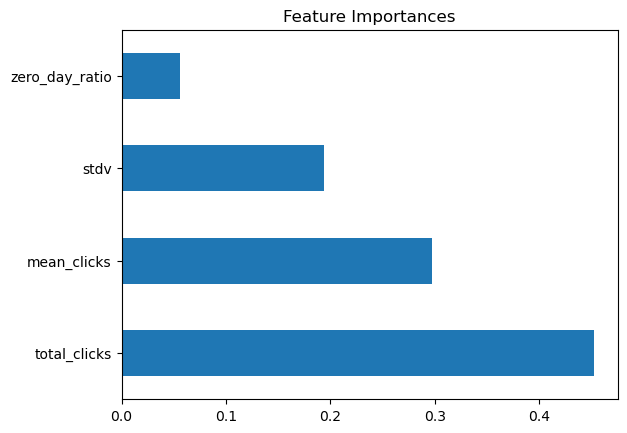

In [36]:
# get importance
importances = classifier.feature_importances_
from matplotlib import pyplot as plt
plt.title('Feature Importances')
plt.xlabel('Relative Importance')

feat_importances = pd.Series(classifier.feature_importances_, index=merged_df_AAA_2013J.iloc[:,1:5].columns)
feat_importances.nlargest(4).plot(kind='barh')

In [37]:
#Logistic regression with undersampling has the best recall of 83% for the negative outcome while maintaining a 
#decent accuracy of 81.6%.

In [38]:
#We want to create interaction metrics from click data that only go out to n days after start date.
#We can find the best n that preserves accuracy while being as low as possible so that we can give the warning signal as
#early as possible.

#Create a new dataframe that has student id, mean of total daily clicks, ratio of zero-click days, and standard deviation of total daily clicks
def df_interaction_n(code_module,code_presentation,n):

    list_student_ids = df_grouped[(df_grouped['code_module']==code_module) & (df_grouped['code_presentation']==code_presentation)]['id_student'].unique()
    # Initialize an empty list to store the data
    data = []

    # Loop through each student ID
    for student_id in list_student_ids:
        # Filter the DataFrame for the current student ID
        filtered_df = complete_df(code_module,code_presentation,student_id)
        filtered_n_df = filtered_df[filtered_df['date'] <= n]
        # Handling cases where filtered_n_df might be empty
        if not filtered_n_df.empty:
            mean_clicks = filtered_n_df['total_daily_clicks'].mean()
            zero_click_days = (filtered_n_df['total_daily_clicks'] == 0).sum()
            total_days = filtered_n_df.shape[0]
            stdv = filtered_n_df['total_daily_clicks'].std()
            total_clicks = filtered_n_df['total_daily_clicks'].sum()
        else:
            # Default values when there's no data within the given period
            mean_clicks = 0
            zero_click_days = 0
            total_days = 0
            zero_day_ratio = 0  # Adjusted to avoid division by zero
            stdv = 0
            total_clicks = 0

        # Compute the ratio of zero-click days, ensuring not to divide by zero
        zero_day_ratio = zero_click_days / total_days if total_days > 0 else 0
        # Handling NaN for stdv explicitly if stdv calculation results in NaN
        stdv = 0 if pd.isna(stdv) else stdv

#         # Calculate the mean of the 'total_clicks' column for this student
#         mean_clicks = filtered_df[filtered_df['date']<=n]['total_daily_clicks'].mean()

#         # Count the number of zero-click days
#         zero_click_days = (filtered_df[filtered_df['date']<=n]['total_daily_clicks'] == 0).sum()

#         # Calculate the total number of days recorded for the student
#         total_days = filtered_df[filtered_df['date']<=n].shape[0]

#         # Compute the ratio of zero-click days
#         zero_day_ratio = zero_click_days / total_days

#         # Calculate the standard deviation of 'total_daily_clicks'
#         stdv = filtered_df[filtered_df['date']<=n]['total_daily_clicks'].std()
#         # Sum of 'total_daily_clicks' for this student
#         total_clicks = filtered_df['total_daily_clicks'].sum()

        # Append the student ID, mean clicks, zero_day_ratio, and standard deviation to the list
        data.append([student_id, mean_clicks, zero_day_ratio, stdv, total_clicks])

    # Create a new DataFrame from the list
    df_summary = pd.DataFrame(data, columns=['id_student', 'mean_clicks', 'zero_day_ratio', 'stdv','total_clicks'])
    return df_summary


In [39]:
df_AAA_2013J = df_interaction_n('AAA','2013J',5)
df_AAA_2013J



,id_student,mean_clicks,zero_day_ratio,stdv,total_clicks
0,11391,25.272727,0.636364,45.961051,278.0
1,28400,19.812500,0.312500,25.804958,317.0
2,30268,12.062500,0.500000,18.855481,193.0
3,31604,11.937500,0.625000,22.269467,191.0
4,32885,21.375000,0.250000,27.815763,342.0
...,...,...,...,...,...
373,2689958,18.062500,0.062500,15.411981,289.0
374,2691206,20.875000,0.187500,25.770461,334.0
375,2691244,2.571429,0.642857,4.702115,36.0
376,2694424,0.933333,0.933333,3.614784,14.0


In [40]:
#join student info dataset with interaction dataset
merged_df_AAA_2013J = pd.merge(df_AAA_2013J, df_student_info_AAA_2013J, on='id_student', how='inner')
merged_df_AAA_2013J

,id_student,mean_clicks,zero_day_ratio,stdv,total_clicks,code_module,code_presentation,outcome
0,11391,25.272727,0.636364,45.961051,278.0,AAA,2013J,1
1,28400,19.812500,0.312500,25.804958,317.0,AAA,2013J,1
2,30268,12.062500,0.500000,18.855481,193.0,AAA,2013J,0
3,31604,11.937500,0.625000,22.269467,191.0,AAA,2013J,1
4,32885,21.375000,0.250000,27.815763,342.0,AAA,2013J,1
...,...,...,...,...,...,...,...,...
373,2689958,18.062500,0.062500,15.411981,289.0,AAA,2013J,1
374,2691206,20.875000,0.187500,25.770461,334.0,AAA,2013J,1
375,2691244,2.571429,0.642857,4.702115,36.0,AAA,2013J,1
376,2694424,0.933333,0.933333,3.614784,14.0,AAA,2013J,1


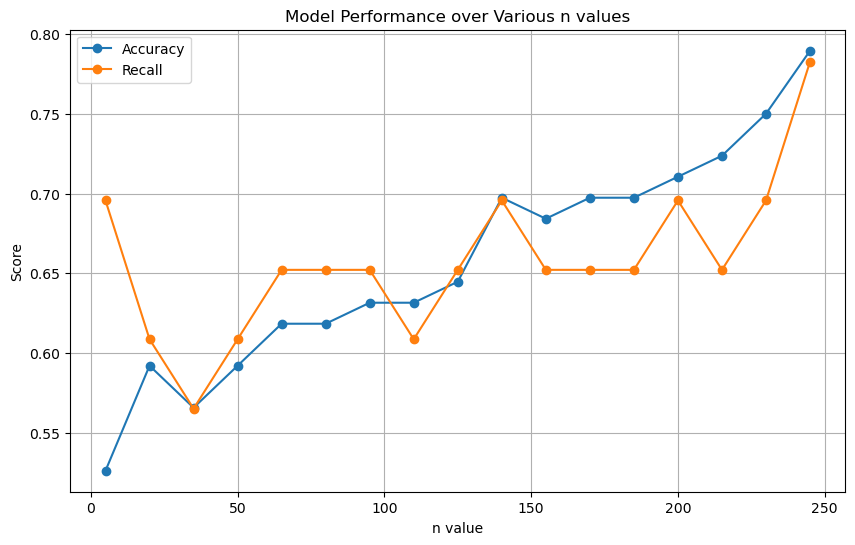

In [41]:
from sklearn.metrics import accuracy_score, recall_score
n_values = np.arange(5,250,15)
accuracy_scores = []
recall_scores = []

# Loop over each value of n
for n in n_values:
    df_AAA_2013J = df_interaction_n('AAA','2013J',n)
    #join student info dataset with interaction dataset
    merged_df_AAA_2013J = pd.merge(df_AAA_2013J, df_student_info_AAA_2013J, on='id_student', how='inner')
    #Define X and Y using dataset
    X = merged_df_AAA_2013J.iloc[:,1:5].values
    Y = merged_df_AAA_2013J.iloc[:,7].values

    #Splitting the dataset into the Training set and Test set
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = 2)

    #Feature Scaling
    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.fit_transform(X_test)
    
    # Randomly under sample the majority class
    rus = RandomUnderSampler(random_state=42)
    X_train_rus, Y_train_rus= rus.fit_resample(X_train, Y_train)
    
    #Fitting Logistic Regression to the randomly under-sampled Training set
    classifier_rus = LogisticRegression()
    classifier_rus.fit(X_train_rus,Y_train_rus)

    #Predicting the Test set results
    Y_pred_rus = classifier_rus.predict(X_test)
    
    # Calculating accuracy and recall
    acc = accuracy_score(Y_test, Y_pred_rus)
    rec = recall_score(Y_test, Y_pred_rus, pos_label=0)
    
    # Appending the scores
    accuracy_scores.append(acc)
    recall_scores.append(rec)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_values, accuracy_scores, label='Accuracy', marker='o')
plt.plot(n_values, recall_scores, label='Recall', marker='o')
plt.xlabel('n value')
plt.ylabel('Score')
plt.title('Model Performance over Various n values')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
#We want to balance accuracy and recall on the one hand and the number of days after course start on the other hand;
#we want the number of days before course start to be as small as possible in order to do catch at-risk students as
#early as possible, but we also want high accuracy and recall in order to identify at-risk students successfully.  
#The accuracy and recall continue to increase as the number of days increases, but we need to pick a point in time
#where the accuracy and recall are good enough.  

#From the above graph, it looks like 75 days out from start date would be a good trade-off point.  The recall is roughly 65%
#and the accuracy is roughly 63%.  

In [43]:
#Create dataset with interaction predictors to hand off to Maysam
df_AAA_2013J_75 = df_interaction_n('AAA','2013J',75)
df_AAA_2013J_75.to_csv('df_AAA_2013J_75.csv', index=False)
df_AAA_2014J_75 = df_interaction_n('AAA','2014J',75)
df_AAA_2014J_75.to_csv('df_AAA_2014J_75.csv', index=False)

In [44]:
df_BBB_2013B_75 = df_interaction_n('BBB','2013B',75)
df_BBB_2013B_75.to_csv('df_BBB_2013B_75.csv', index=False)
df_BBB_2013J_75 = df_interaction_n('BBB','2013J',75)
df_BBB_2013J_75.to_csv('df_BBB_2013J_75.csv', index=False)
df_BBB_2014B_75 = df_interaction_n('BBB','2014B',75)
df_BBB_2014B_75.to_csv('df_BBB_2014B_75.csv', index=False)
df_BBB_2014J_75 = df_interaction_n('BBB','2014J',75)
df_BBB_2014J_75.to_csv('df_BBB_2014J_75.csv', index=False)

In [45]:
df_CCC_2014B_75 = df_interaction_n('CCC','2014B',75)
df_CCC_2014B_75.to_csv('df_CCC_2014B_75.csv', index=False)
df_CCC_2014J_75 = df_interaction_n('CCC','2014J',75)
df_CCC_2014J_75.to_csv('df_CCC_2014J_75.csv', index=False)

In [46]:
df_DDD_2013B_75 = df_interaction_n('DDD','2013B',75)
df_DDD_2013B_75.to_csv('df_DDD_2013B_75.csv', index=False)
df_DDD_2013J_75 = df_interaction_n('DDD','2013J',75)
df_DDD_2013J_75.to_csv('df_DDD_2013J_75.csv', index=False)
df_DDD_2014B_75 = df_interaction_n('DDD','2014B',75)
df_DDD_2014B_75.to_csv('df_DDD_2014B_75.csv', index=False)
df_DDD_2014J_75 = df_interaction_n('DDD','2014J',75)
df_DDD_2014J_75.to_csv('df_DDD_2014J_75.csv', index=False)

In [47]:
df_EEE_2013J_75 = df_interaction_n('EEE','2013J',75)
df_EEE_2013J_75.to_csv('df_EEE_2013J_75.csv', index=False)
df_EEE_2014B_75 = df_interaction_n('EEE','2014B',75)
df_EEE_2014B_75.to_csv('df_EEE_2014B_75.csv', index=False)
df_EEE_2014J_75 = df_interaction_n('EEE','2014J',75)
df_EEE_2014J_75.to_csv('df_EEE_2014J_75.csv', index=False)

In [48]:
df_FFF_2013B_75 = df_interaction_n('FFF','2013B',75)
df_FFF_2013B_75.to_csv('df_FFF_2013B_75.csv', index=False)
df_FFF_2013J_75 = df_interaction_n('FFF','2013J',75)
df_FFF_2013J_75.to_csv('df_FFF_2013J_75.csv', index=False)
df_FFF_2014B_75 = df_interaction_n('FFF','2014B',75)
df_FFF_2014B_75.to_csv('df_FFF_2014B_75.csv', index=False)
df_FFF_2014J_75 = df_interaction_n('FFF','2014J',75)
df_FFF_2014J_75.to_csv('df_FFF_2014J_75.csv', index=False)

In [49]:
df_GGG_2013J_75 = df_interaction_n('GGG','2013J',75)
df_GGG_2013J_75.to_csv('df_GGG_2013J_75.csv', index=False)
df_GGG_2014B_75 = df_interaction_n('GGG','2014B',75)
df_GGG_2014B_75.to_csv('df_GGG_2014B_75.csv', index=False)
df_GGG_2014J_75 = df_interaction_n('GGG','2014J',75)
df_GGG_2014J_75.to_csv('df_GGG_2014J_75.csv', index=False)